# Обработка данных

### Импортирование библиотек

In [1]:
import pandas as pd 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

import matplotlib.pyplot as plt 

from sklearn.metrics import f1_score, roc_auc_score

from sentence_transformers import SentenceTransformer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


data = pd.read_excel('project/dirty_data.xlsx')

### Работа со столбцами

In [2]:
tags = ['Вопрос решен', 'Вопрос не решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки']

for tag in tags:
    data[tag] = data['taxonomy'].apply(lambda x: 1 if pd.notna(x) and tag in x else 0)


delete_columns = ['annotation_id', 'annotator', 'id', 'created_at', 'taxonomy', 'lead_time', 'updated_at']
data.drop(columns=delete_columns, inplace=True)

In [3]:
print(data.shape)
data

(2372, 8)


,comment,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Вопрос не решен
0,спасибо,5,1,0,0,0,0,0
1,спасибо!,5,1,0,0,0,0,0
2,Отлично,5,1,0,0,0,0,0
3,Благодарю за оперативное решение проблемы !,5,1,0,0,1,0,0
4,Прекрасный специалист! Побольше таких,5,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2367,"долго, но приятно",5,1,0,0,0,0,0
2368,16.03.2024 г ребята установили кондиционер. ра...,5,1,1,1,1,0,0
2369,два дня мусоропровод. сегодня с утра тоже,5,0,0,0,0,0,1
2370,отрегулировать дверь замки . для должного откр...,5,0,0,0,0,0,1


### Удаление уникальных грязных отзывов (смайлики)

In [4]:
data = data.drop(1194).reset_index(drop=True)
data = data.drop(1308).reset_index(drop=True)
data = data.drop(2098).reset_index(drop=True)

data.to_excel('data_normal.xlsx', index=False)

### Нормализация отзывов

In [5]:
data['comment_clean'] = data['comment'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
data_clean = data.drop_duplicates(subset=['comment_clean'])

### График распределения классов

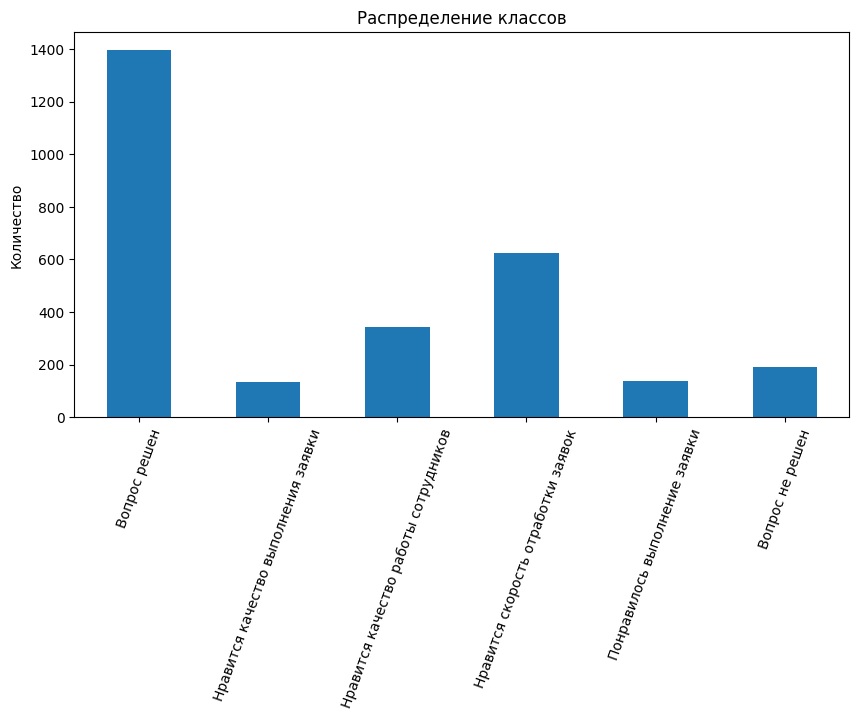

In [6]:
class_columns = data_clean.columns[2:-1]  
class_distribution = data_clean[class_columns].sum()

plt.figure(figsize=(10, 5))
class_distribution.plot(kind="bar", rot=70)
plt.title("Распределение классов")
plt.ylabel("Количество")
plt.show()

# Baseline-модель

### Загрузка готовой модели и тегов

In [7]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

labels = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Вопрос не решен'
]

Device set to use cpu


### Предсказание

In [8]:
scores = []
results = []

for text in data_clean['comment_clean'][:20]:
    result = classifier(text, candidate_labels=labels, hypothesis_template="Этот отзыв про {}.")
    pred_bin = [1 if score > 0.5 else 0 for score in result['scores']]
    results.append(pred_bin)
    scores.append(result['scores'])

results = np.array(results)
scores = np.array(results)
true_labels = data_clean[labels].values.astype(int)[:20]

### Вывод результатов

In [9]:
print("F1 micro:", f1_score(true_labels, results, average='micro'))
print("ROC-AUC micro:", roc_auc_score(true_labels, scores, average='micro'))

F1 micro: 0.0
ROC-AUC micro: 0.5


# Sbert

### Предобученная модель для преобразовани текста в вектор

In [10]:
model_sbert = SentenceTransformer('cointegrated/rubert-tiny2')

### Кодировка текста в вектор

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, dataframe, text_column, label_columns, model):
        self.texts = dataframe[text_column].tolist()
        self.labels = dataframe[label_columns].values.astype('float32')
        self.model = model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        embedding = self.model.encode(text, convert_to_tensor=True)
        label = torch.tensor(self.labels[idx])
        return embedding, label

### Классификтор вероятностей для каждой метки 

In [ ]:
class MultiLabelClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.hidden = nn.Linear(embedding_dim, embedding_dim)  # Можно оставить ту же размерность
        self.output = nn.Linear(embedding_dim, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return torch.sigmoid(x)

### Подготовка данных

In [13]:
dataset = ReviewDataset(data, text_column='comment', label_columns=labels, model=model_sbert)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

### Инициализация модели

In [14]:
model = MultiLabelClassifier(312, 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

## Функции

### Подготовка данных к обучению

In [15]:
def prepare_dataloaders(train_df, test_df, model_sbert, labels, batch_size=32):
    train_dataset = ReviewDataset(train_df, text_column='comment', label_columns=labels, model=model_sbert)
    test_dataset = ReviewDataset(test_df, text_column='comment', label_columns=labels, model=model_sbert)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### Функция обучения 

In [16]:
def train_model(train_loader, embedding_dim, num_labels, epochs=10):
    model = MultiLabelClassifier(embedding_dim, num_labels)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(epochs):
        for embeddings, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    return model

### Функция предсказания

In [17]:
def predict_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        preds = torch.cat([model(emb) for emb, _ in data_loader]).cpu().numpy()
        labels = torch.cat([tgt for _, tgt in data_loader]).cpu().numpy()
    return preds, labels

### Расчет ROC-AUC

In [18]:
def calculate_auc(labels, preds):
    auc_per_tag = [roc_auc_score(labels[:, i], preds[:, i]) for i in range(labels.shape[1])]
    micro_auc = roc_auc_score(labels.ravel(), preds.ravel())
    return auc_per_tag, micro_auc

### Подбор лучшего порога по f1 для каждого класса

In [19]:
def optimize_f1_thresholds(labels, preds, thresholds=np.linspace(0.0, 1.0, 101)):
    optimal_thresholds = []
    f1_per_tag = []
    for i in range(labels.shape[1]):
        best_f1, best_thresh = max(
            ((f1_score(labels[:, i], (preds[:, i] >= t).astype(int), zero_division=0), t) for t in thresholds),
            key=lambda x: x[0]
        )
        optimal_thresholds.append(best_thresh)
        f1_per_tag.append(best_f1)
    return optimal_thresholds, f1_per_tag

### Применеие порога к вероятности

In [20]:
def apply_thresholds(preds, thresholds):
    binarized = []
    for i, threshold in enumerate(thresholds):
        binary_column = (preds[:, i] >= threshold).astype(int)
        binarized.append(binary_column)
    return np.array(binarized).T

### Сбор всех метрик

In [21]:
def evaluate_model(train_labels, train_preds, test_labels, test_preds):
    train_auc, train_micro_auc = calculate_auc(train_labels, train_preds)
    test_auc, test_micro_auc = calculate_auc(test_labels, test_preds)
    optimal_thresholds, train_f1_per_tag = optimize_f1_thresholds(train_labels, train_preds)

    train_preds_bin = apply_thresholds(train_preds, optimal_thresholds)
    micro_f1_train = f1_score(train_labels, train_preds_bin, average='micro')

    test_preds_bin = apply_thresholds(test_preds, optimal_thresholds)
    micro_f1_test = f1_score(test_labels, test_preds_bin, average='micro')

    return {'train_micro_auc': train_micro_auc, 'test_micro_auc': test_micro_auc, 'train_micro_f1': micro_f1_train, 'test_micro_f1': micro_f1_test}

### График разницы train и test AUC (не используется)

In [22]:
def plot_roc_auc_gap(train_micro_auc, test_micro_auc):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(['Train', 'Test'], [train_micro_auc, test_micro_auc], color=['green', 'orange'])
    plt.ylim(0, 1)
    plt.title(f'Micro ROC-AUC\nGap = {abs(train_micro_auc - test_micro_auc):.4f}')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, f'{bar.get_height():.4f}', ha='center', va='bottom')
    plt.show()

### Функция объединения обучения и предсказания

In [23]:
def train_and_evaluate(train_loader, test_loader, embedding_dim, num_labels):
    model = train_model(train_loader, embedding_dim, num_labels)
    train_preds, train_labels = predict_model(model, train_loader)
    test_preds, test_labels = predict_model(model, test_loader)
    return evaluate_model(train_labels, train_preds, test_labels, test_preds)

# Применение функций обучения, предсказания и оценки

### Кросс-валидация обучения

In [24]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_per_fold = []

for fold, (train_idx, test_idx) in enumerate(mskf.split(data_clean, data_clean[labels])):
    print(f'\n--- Fold {fold+1} ---')
    train_df = data_clean.iloc[train_idx]
    test_df = data_clean.iloc[test_idx]

    train_loader, test_loader = prepare_dataloaders(train_df, test_df, model_sbert, labels)
    fold_results = train_and_evaluate(train_loader, test_loader, 312, len(labels))
    results_per_fold.append(fold_results)

    model = train_model(train_loader, 312, len(labels))
    train_preds, train_labels = predict_model(model, train_loader)
    last_model = model
    last_thresholds, _ = optimize_f1_thresholds(train_labels, train_preds)  


--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


### Вывод результатов оценки

In [25]:
print('\n--- Average results ---')
print('Train Micro AUC:', np.mean([r['train_micro_auc'] for r in results_per_fold]))
print('Test Micro AUC:', np.mean([r['test_micro_auc'] for r in results_per_fold]))
print('Train Micro F1:', np.mean([r['train_micro_f1'] for r in results_per_fold]))
print('Test Micro F1:', np.mean([r['test_micro_f1'] for r in results_per_fold]))


--- Average results ---
Train Micro AUC: 0.972368670902967
Test Micro AUC: 0.9651991958782629
Train Micro F1: 0.8760593023447155
Test Micro F1: 0.8551704787830909


### Сохранение модели

In [26]:
torch.save(last_model.state_dict(), 'final_model.pth')

## Ручное предсказание по новому отзыву

### Функция предсказания по новому отзыву

In [27]:
def predict_single_text(text, model, sbert_model, thresholds, label_list):
    model.eval()
    with torch.no_grad():
        emb = sbert_model.encode(text, convert_to_tensor=True).unsqueeze(0)  # добавляем batch dimension
        preds = model(emb).cpu().numpy()[0]
        preds_bin = (preds >= thresholds).astype(int)
        predicted_tags = [label for label, pred in zip(label_list, preds_bin) if pred == 1]
    return predicted_tags, preds

### Вывод результатов предсказания

In [ ]:
new_text = "оперативно приехали, все хорошо"

predicted_tags, raw_scores = predict_single_text(new_text, last_model, model_sbert, last_thresholds, labels)

print(f"Текст: {new_text}")
print(f"Предсказанные теги: {predicted_tags}")
print(f"Raw scores: {raw_scores}")

Текст: оперативно приехали, все хорошо
Предсказанные теги: ['Вопрос решен', 'Нравится скорость отработки заявок']
Raw scores: [9.9911302e-01 6.8695456e-02 2.5429146e-02 9.0356541e-01 8.5563302e-02
 6.8349228e-04]


### График ROC-AUC кривых

In [40]:
from sklearn.metrics import roc_curve, auc
def plot_multilabel_roc(labels, preds, class_names=None):
    n_classes = labels.shape[1]
    plt.figure(figsize=(10, 7))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        label = f'{class_names[i] if class_names else f"Class {i}"} (AUC = {roc_auc:.2f})'
        plt.plot(fpr, tpr, lw=2, label=label)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC кривые для каждого класса (MultiLabelClassifier(torch)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

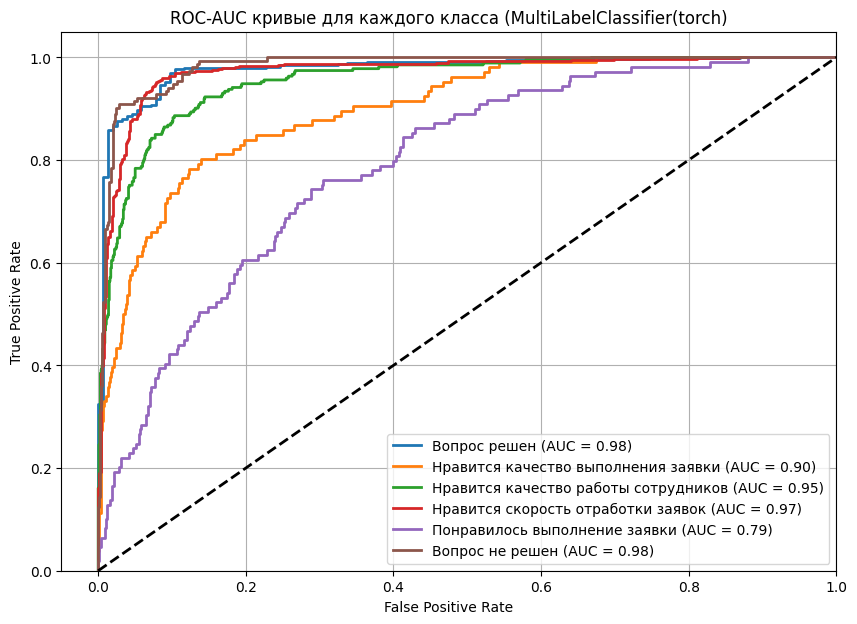

In [ ]:
plot_multilabel_roc(train_labels, train_preds, class_names=labels)